# Base Accuracy:
- The base accuracy after training for 100 epochs is **83.54%**
- So the target is to beat this accuracy with modifivations in the model

## Import Modules and Libraries

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


## Import CiFAR Dataset
- It is a more advance dataset compared to MNIST
- It has 10 classes 
- The dimension of the images are 32x32x3 since it is a RGB image
- Shown below are the classses in the CiFAR dataset
- Like MNIST, CiFAR also has 50K training images and labels as well as 10K test images and labels

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 55s 0us/step


## Print training data dimensions

In [0]:
print(train_features.shape)

(50000, 32, 32, 3)


## Displaying a sample from each class of the dataset

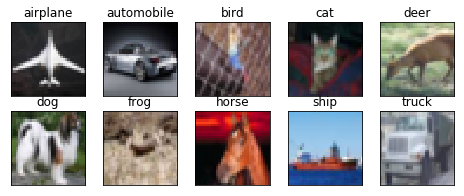

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Function for plotting accuracy and loss during model training

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Accuracy Calculation for a model

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Data Float Conversion , remapping pixel values between 0 & 1, and One-Hot encoding

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Model Architecture and Compiling Model
- First thing I changed is the model architecture
- I have implemented a model with convolution block, transition block and output block
![](model.png)
- The convolution blocks extract the features from the data while the transition block combine this information in fewer channels and also reduce the size of the model
- The number of layers were added bassed on the Receptive field of the model
- With the below changes in the architecture, I got an accuracy around the base accuraccy 
- Then, I reduced number of kernels to reduce the number of parameters
- Then I added Dropout to reduce the overfitting
- Adding Batch Normalization layer gave the required accuracy within 100 epochs
- **Accuracy of 84.32% was achieved in 87th epoch**

In [0]:
# Define the model
model = Sequential()

drop = 0.35

# Convolution Block
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(32, 32, 3))) # Output: 32x32x32    |    Receptive Field: 3x3
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(64, 3, 3, border_mode='same'))                          # Output: 32x32x64    |    Receptive Field: 3x3
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(128, 3, 3, border_mode='same'))                         # Output: 32x32x128    |    Receptive Field: 3x3
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(drop))

# Transition Block
model.add(MaxPooling2D(pool_size=(2, 2)))                                       # Output: 16x16x128    |    Receptive Field: 6x6
model.add(Convolution2D(64, 1, 1))                                              # Output: 16x16x64     |    Receptive Field: 6x6
model.add(Activation('relu'))
model.add(BatchNormalization())

# Convolution Block
model.add(Convolution2D(64, 3, 3, border_mode='same'))                          # Output: 16x16x64     |    Receptive Field: 6x6
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(128, 3, 3, border_mode='same'))                         # Output: 16x16x128    |    Receptive Field: 6x6
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(drop))

# Transition Block
model.add(MaxPooling2D(pool_size=(2, 2)))                                       # Output: 8x8x128      |    Receptive Field: 12x12 
model.add(Convolution2D(64, 1, 1))                                              # Output: 8x8x64       |    Receptive Field: 12x12
model.add(Activation('relu'))
model.add(BatchNormalization())

# Convolution Block
model.add(Convolution2D(64, 3, 3, border_mode='same'))                          # Output: 8x8x64       |    Receptive Field: 12x12
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(128, 3, 3, border_mode='same'))                         # Output: 8x8x128      |    Receptive Field: 12x12
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(drop))

# Transition Block
model.add(Convolution2D(64, 1, 1))                                              # Output: 8x8x64       |    Receptive Field: 12x12
model.add(BatchNormalization())
model.add(Convolution2D(num_classes, 8, 8))                                     # Output: 1x1x10       |    Receptive Field:  20x20

# Output Block
model.add(Flatten())                                                            
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1))`
/usr/local/l

## Model Summary

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
__________

## Model Training and progress tracking

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 29s 75ms/step - loss: 1.4607 - acc: 0.5004 - val_loss: 1.3312 - val_acc: 0.5229
Epoch 2/100
390/390 [==============================] - 25s 64ms/step - loss: 0.9303 - acc: 0.6753 - val_loss: 1.1876 - val_acc: 0.5823
Epoch 3/100
390/390 [==============================] - 24s 63ms/step - loss: 0.7445 - acc: 0.7402 - val_loss: 1.1738 - val_acc: 0.5880
Epoch 4/100
390/390 [==============================] - 24s 62ms/step - loss: 0.6409 - acc: 0.7783 - val_loss: 0.7512 - val_acc: 0.7430
Epoch 5/100
390/390 [==============================] - 24s 62ms/step - loss: 0.5608 - acc: 0.8036 - val_loss: 0.8781 - val_acc: 0.6843
Epoch 6/100
390/390 [==============================] - 24s 62ms/step - loss: 0.4985 - acc: 0.8278 - val_loss: 0.7295 - val_acc: 0.7495
Epoch 7/100
390/390 [==============================] - 24s 62ms/step - loss: 0.4513 - acc: 0.8436 - val_loss: 0.8789 - val_acc: 0.6988
Epoch 8/100
390/390 [==============================] - 

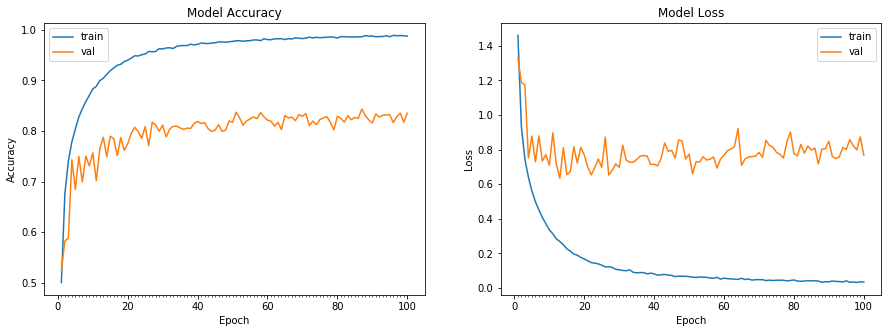

Accuracy on test data is: 83.52


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

## 84.32% - (87th Epoch)